In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import dandelion as ddl
sc.logging.print_header()

warnings.filterwarnings('ignore')
os.chdir('/lustre/scratch117/cellgen/team297/kt16/Ziad/scanpy')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.4 scipy==1.6.0 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


In [2]:
rna = sc.read_h5ad('h5ad/adata_soupx_trans_cite_rna.h5ad')

In [3]:
sorted(list(set(rna.obs['fine_clustering'])))

['B_naive',
 'B_non-switched_memory',
 'B_switched_memory',
 'CD16neg_NK',
 'CD16pos_NK',
 'CD16pos_SIGLEC7_NK',
 'CD4_CD25_IL17RB_T/NKT',
 'CD4_Tcm',
 'CD4_Tem',
 'CD4_Tnaive',
 'CD4_Treg',
 'CD8_Tem',
 'CD8_Temra',
 'CD8_Tnaive',
 'Classical_mono',
 'Erythrocyte',
 'HSC',
 'Intermediate_mono',
 'MAIT',
 'Megakaryocyte',
 'NKT',
 'Non-classical_mono',
 'Non-classical_mono_C1Q+',
 'Plasmablast',
 'Proliferating_lymphocyte',
 'Vd1_gdT',
 'Vd2_gdT',
 'cDC1',
 'cDC2',
 'doublets',
 'pDC']

In [4]:
# subset to the T and NK cells
rnax = rna[(rna.obs['fine_clustering'].isin(['B_naive','B_non-switched_memory','B_switched_memory','Plasmablast']))].raw.to_adata().copy()
# Identify highly-variable genes
sc.pp.highly_variable_genes(rnax, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
## remove TRBV/TRAV and IGHV/IGLV/IGKV from the highly variable genes
import re
for i in rnax.var.index:
    if re.search('^IG[HKL][VDJC]', i):
        rnax.var.at[i, 'highly_variable'] = False
# sc.pl.highly_variable_genes(rnax)
# stash the normalized data in raw
rnax.raw = rnax
# filter to only highly variable
rnax = rnax[:, rnax.var['highly_variable']]

In [5]:
import multiprocessing
# regress and scale for PCA
sc.pp.regress_out(rnax, ['total_counts', 'pct_counts_mt'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(rnax, max_value = 10)
sc.tl.pca(rnax, svd_solver = 'arpack')

In [6]:
# run harmony. compute the neighborhood graph.
sc.external.pp.harmony_integrate(rnax, key='study_id')
sc.pp.neighbors(rnax, use_rep = 'X_pca_harmony')

2021-03-23 11:18:06,795 - harmonypy - INFO - Iteration 1 of 10
2021-03-23 11:18:10,201 - harmonypy - INFO - Iteration 2 of 10
2021-03-23 11:18:13,729 - harmonypy - INFO - Iteration 3 of 10
2021-03-23 11:18:18,488 - harmonypy - INFO - Iteration 4 of 10
2021-03-23 11:18:20,523 - harmonypy - INFO - Iteration 5 of 10
2021-03-23 11:18:22,636 - harmonypy - INFO - Iteration 6 of 10
2021-03-23 11:18:24,275 - harmonypy - INFO - Iteration 7 of 10
2021-03-23 11:18:25,893 - harmonypy - INFO - Iteration 8 of 10
2021-03-23 11:18:27,562 - harmonypy - INFO - Iteration 9 of 10
2021-03-23 11:18:29,215 - harmonypy - INFO - Iteration 10 of 10
2021-03-23 11:18:31,825 - harmonypy - INFO - Stopped before convergence


In [7]:
# run UMAP
sc.tl.umap(rnax, min_dist = 0.3)

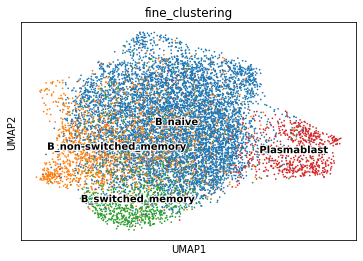

In [8]:
# find clusters
sc.pl.umap(rnax, color=['fine_clustering'], legend_loc ='on data', legend_fontoutline=2)

In [9]:
rnax.write('h5ad/B_rna.h5ad', compression = 'gzip')

### Setup for milo

First, split the 1.5 vs untreated and 2.5 vs untreated into 2 objects

In [10]:
rnax1 = rnax[rnax.obs['treatment'].isin(['Saline', '1.5MIU'])].copy()
rnax2 = rnax[rnax.obs['treatment'].isin(['Saline', '2.5MIU'])].copy()

In [11]:
rna.obs

,sampleid,sampleid_study,timepoint,treatment,study_id,scrublet_score,n_genes,percent_mito,n_counts,is_doublet,...,BNP,on_treatment_CRP,AEs,treatment_group_1,treatment_group_2,Lymph,CD4,CD8,Treg,sample_id
Sample_Fq1_AAACCTGAGATTACCC,Sample_Fq1,L6010T2,pre,Saline,L6010,0.053861,870,2.876169,1941.831651,False,...,75,9.0,0,untreated,untreated,1.255,0.35200,0.16300,0.026,Sample_Fq1
Sample_Fq1_AAACCTGAGCCCAATT,Sample_Fq1,L6010T2,pre,Saline,L6010,0.128095,1031,5.500396,2031.293912,False,...,75,9.0,0,untreated,untreated,1.255,0.35200,0.16300,0.026,Sample_Fq1
Sample_Fq1_AAACCTGAGGGTCTCC,Sample_Fq1,L6010T2,pre,Saline,L6010,0.023124,576,1.723816,1485.500157,False,...,75,9.0,0,untreated,untreated,1.255,0.35200,0.16300,0.026,Sample_Fq1
Sample_Fq1_AAACCTGAGGTGCTAG,Sample_Fq1,L6010T2,pre,Saline,L6010,0.060440,991,1.640358,2419.141384,False,...,75,9.0,0,untreated,untreated,1.255,0.35200,0.16300,0.026,Sample_Fq1
Sample_Fq1_AAACCTGCAAGCCTAT,Sample_Fq1,L6010T2,pre,Saline,L6010,0.104225,839,3.271511,1538.276287,False,...,75,9.0,0,untreated,untreated,1.255,0.35200,0.16300,0.026,Sample_Fq1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_Fq32_TTTGTCAGTGTCCTCT,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.010219,548,6.286075,1263.726819,False,...,936,19.7,1,2.5MIU,treated,1.131,0.52026,0.24882,0.072,Sample_Fq32
Sample_Fq32_TTTGTCAGTTACAGAA,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.090526,825,4.654680,1595.441862,False,...,936,19.7,1,2.5MIU,treated,1.131,0.52026,0.24882,0.072,Sample_Fq32
Sample_Fq32_TTTGTCATCCTAGAAC,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.123077,2134,3.495720,6932.107353,False,...,936,19.7,1,2.5MIU,treated,1.131,0.52026,0.24882,0.072,Sample_Fq32
Sample_Fq32_TTTGTCATCGTGGACC,Sample_Fq32,L7003T7,post,2.5MIU,L7003,0.064125,1152,4.524075,2839.560090,False,...,936,19.7,1,2.5MIU,treated,1.131,0.52026,0.24882,0.072,Sample_Fq32


anndata2ri converter doesn't seem to like converting anndata objects storing the KNN graph in the adata.obsp slot, probably because there is no dedicated slot in the SingleCellExperiment object. Because of this, we will first make a copy of our anndata without KNN graph for conversion.

In [12]:
# store the neighborhood graph separately
adata_no_knnx1 = rnax1.copy()
adata_no_knnx1.obsp = None
adata_no_knnx1.uns.pop("neighbors")

adata_no_knnx2 = rnax2.copy()
adata_no_knnx2.obsp = None
adata_no_knnx2.uns.pop("neighbors")

## Save the binary connectivity matrix
knn_adjacencyx1 = rnax1.obsp["connectivities"]
knn_adjacencyx2 = rnax2.obsp["connectivities"]

use the anndata2ri package to allow conversion between anndata and SingleCellExperiment objects

In [13]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [14]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [15]:
anndata2ri.activate()

In [16]:
%load_ext rpy2.ipython

In [17]:
%%R
## Count cells in neighbourhoods
countCells_ <- function(x, samples, meta.data=NULL){

    # cast dplyr objects to data.frame
    if(!is.data.frame(meta.data) & !is.null(meta.data)){
        meta.data <- as.data.frame(meta.data)
    }

    if(length(samples) > 1 & !is.null(meta.data)){
        stop("Multiple sample columns provided, please specify a unique column name")
    } else if(is.null(meta.data) & length(samples) != ncol(x)){
        stop(paste0("Length of vector does not match dimensions of object. Length:",
                    length(samples), " Dimensions: ", ncol(x)))
    }

    # check the nhoods slot is populated
    if(ncol(nhoods(x)) == 1 & nrow(nhoods(x)) == 1){
        stop("No neighbourhoods found. Please run makeNhoods() first.")
    }

    message("Checking meta.data validity")
    if(!is.null(meta.data)){
        samp.ids <- unique(as.character(meta.data[, samples]))
    } else {
        samp.ids <- unique(as.character(samples))
    }

    num.hoods <- ncol(nhoods(x))

    ## Convert meta data to binary dummies in sparse matrix
    dummy.meta.data <- Matrix(data=0, nrow=nrow(meta.data), ncol = length(samp.ids), sparse = TRUE)
    colnames(dummy.meta.data) <- samp.ids
    rownames(dummy.meta.data) <- rownames(meta.data)
    for (s in seq_along(samp.ids)){
        i.s <- samp.ids[s]
        s.ixs <- which(meta.data[samples]==i.s)
        dummy.meta.data[s.ixs, as.character(i.s)] <- 1
    }

    message("Counting cells in neighbourhoods")
    count.matrix <- Matrix::t(nhoods(x)) %*% dummy.meta.data

    # add to the object
    rownames(count.matrix) <- c(1:num.hoods)
    nhoodCounts(x) <- count.matrix

    return(x)
}

In [18]:
%%R -i adata_no_knnx1 -i knn_adjacencyx1
save(countCells_, adata_no_knnx1, knn_adjacencyx1, file = 'h5ad/R/B_milo_prep_1.5.RData')

In [19]:
%%R -i adata_no_knnx2 -i knn_adjacencyx2
save(countCells_, adata_no_knnx2, knn_adjacencyx2, file = 'h5ad/R/B_milo_prep_2.5.RData')

In [20]:
rnax1.write('h5ad/R/B_1.5_prep_milo.h5ad', compression = 'gzip')
rnax2.write('h5ad/R/B_2.5_prep_milo.h5ad', compression = 'gzip')

In [21]:
## MNP

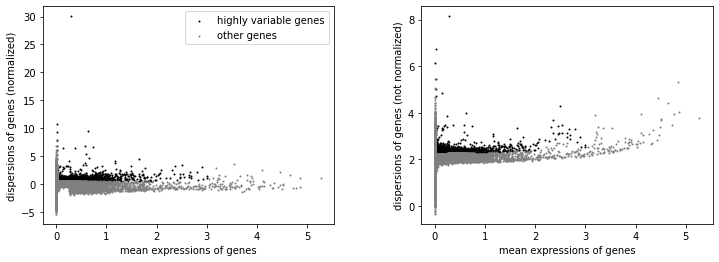

In [9]:
# subset to the T and NK cells
rnax = rna[(rna.obs['fine_clustering'].isin(['Classical_mono',
 # 'HSC',
 'Intermediate_mono',
 'Non-classical_mono',
 'Non-classical_mono_C1Q+',
 'cDC1',
 'cDC2',
 'pDC']))].raw.to_adata().copy()
# Identify highly-variable genes
sc.pp.highly_variable_genes(rnax, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)
## remove TRBV/TRAV and IGHV/IGLV/IGKV from the highly variable genes
sc.pl.highly_variable_genes(rnax)
# stash the normalized data in raw
rnax.raw = rnax
# filter to only highly variable
rnax = rnax[:, rnax.var['highly_variable']]

In [10]:
import multiprocessing
# regress and scale for PCA
sc.pp.regress_out(rnax, ['total_counts', 'pct_counts_mt'], n_jobs = multiprocessing.cpu_count()-1)
sc.pp.scale(rnax, max_value = 10)
sc.tl.pca(rnax, svd_solver = 'arpack')

In [11]:
# run harmony. compute the neighborhood graph.
sc.external.pp.harmony_integrate(rnax, key='study_id')
sc.pp.neighbors(rnax, use_rep = 'X_pca_harmony')

2021-03-15 10:50:11,265 - harmonypy - INFO - Iteration 1 of 10
2021-03-15 10:51:00,039 - harmonypy - INFO - Iteration 2 of 10
2021-03-15 10:51:32,171 - harmonypy - INFO - Converged after 2 iterations


In [12]:
# run UMAP
sc.tl.umap(rnax, min_dist = 0.3)

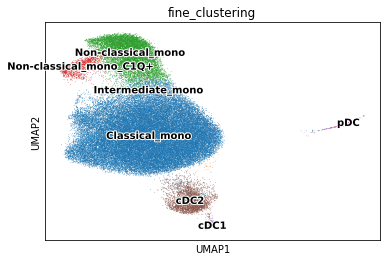

In [13]:
# find clusters
sc.pl.umap(rnax, color=['fine_clustering'], legend_loc ='on data', legend_fontoutline=2)

In [14]:
rnax.write('h5ad/MNP_rna.h5ad', compression = 'gzip')

### Setup for milo

First, split the 1.5 vs untreated and 2.5 vs untreated into 2 objects

In [15]:
rnax1 = rnax[rnax.obs['treatment'].isin(['Saline', '1.5MIU'])].copy()
rnax2 = rnax[rnax.obs['treatment'].isin(['Saline', '2.5MIU'])].copy()

anndata2ri converter doesn't seem to like converting anndata objects storing the KNN graph in the adata.obsp slot, probably because there is no dedicated slot in the SingleCellExperiment object. Because of this, we will first make a copy of our anndata without KNN graph for conversion.

In [16]:
# store the neighborhood graph separately
adata_no_knnx1 = rnax1.copy()
adata_no_knnx1.obsp = None
adata_no_knnx1.uns.pop("neighbors")

adata_no_knnx2 = rnax2.copy()
adata_no_knnx2.obsp = None
adata_no_knnx2.uns.pop("neighbors")

## Save the binary connectivity matrix
knn_adjacencyx1 = rnax1.obsp["connectivities"]
knn_adjacencyx2 = rnax2.obsp["connectivities"]

use the anndata2ri package to allow conversion between anndata and SingleCellExperiment objects

In [17]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [18]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [19]:
anndata2ri.activate()

In [20]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [21]:
%%R
## Count cells in neighbourhoods
countCells_ <- function(x, samples, meta.data=NULL){

    # cast dplyr objects to data.frame
    if(!is.data.frame(meta.data) & !is.null(meta.data)){
        meta.data <- as.data.frame(meta.data)
    }

    if(length(samples) > 1 & !is.null(meta.data)){
        stop("Multiple sample columns provided, please specify a unique column name")
    } else if(is.null(meta.data) & length(samples) != ncol(x)){
        stop(paste0("Length of vector does not match dimensions of object. Length:",
                    length(samples), " Dimensions: ", ncol(x)))
    }

    # check the nhoods slot is populated
    if(ncol(nhoods(x)) == 1 & nrow(nhoods(x)) == 1){
        stop("No neighbourhoods found. Please run makeNhoods() first.")
    }

    message("Checking meta.data validity")
    if(!is.null(meta.data)){
        samp.ids <- unique(as.character(meta.data[, samples]))
    } else {
        samp.ids <- unique(as.character(samples))
    }

    num.hoods <- ncol(nhoods(x))

    ## Convert meta data to binary dummies in sparse matrix
    dummy.meta.data <- Matrix(data=0, nrow=nrow(meta.data), ncol = length(samp.ids), sparse = TRUE)
    colnames(dummy.meta.data) <- samp.ids
    rownames(dummy.meta.data) <- rownames(meta.data)
    for (s in seq_along(samp.ids)){
        i.s <- samp.ids[s]
        s.ixs <- which(meta.data[samples]==i.s)
        dummy.meta.data[s.ixs, as.character(i.s)] <- 1
    }

    message("Counting cells in neighbourhoods")
    count.matrix <- Matrix::t(nhoods(x)) %*% dummy.meta.data

    # add to the object
    rownames(count.matrix) <- c(1:num.hoods)
    nhoodCounts(x) <- count.matrix

    return(x)
}

In [22]:
%%R -i adata_no_knnx1 -i knn_adjacencyx1
save(countCells_, adata_no_knnx1, knn_adjacencyx1, file = 'h5ad/R/MNP_milo_prep_1.5.RData')

In [23]:
%%R -i adata_no_knnx2 -i knn_adjacencyx2
save(countCells_, adata_no_knnx2, knn_adjacencyx2, file = 'h5ad/R/MNP_milo_prep_2.5.RData')

In [24]:
rnax1.write('h5ad/R/MNP_1.5_prep_milo.h5ad', compression = 'gzip')
rnax2.write('h5ad/R/MNP_2.5_prep_milo.h5ad', compression = 'gzip')